In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy import stats
from subprocess import run, check_output
import os
from decimal import Decimal
import random
import matplotlib.pyplot as plt
import time


In [3]:
print(tf.__version__)
np.random.seed(1223)

2.5.0


In [4]:
ROWS = 100
COLS = 3
NAMES = [r'$\mathrm{E}[\beta_1 | X]$',
         r'$\mathrm{E}[\beta_2 | X]$',
         r'$\mathrm{E}[\sigma^2 | X]$',
         r'$Var[\beta_1 | X]$',
         r'$Var[\beta_2 | X]$',
         r'$Var[\sigma^2 | X]$']

In [5]:
# set the path:
PATH = os.getcwd()

os.makedirs('result',exist_ok=True)
os.makedirs('model_checkpoints',exist_ok=True)

# how deep should the model be:
filters = [64,128,128,512]

# number of channels:
nchannels = COLS

# optimizer:
optimizer = 'adam'

#
bnEps = 2e-5
bnMom = 0.9
reg = 0.0001

# Batch size:
batchsize = 64

checkpoint_path = "model_checkpoints/trained_model.hdf5"

In [6]:
def read_data(path,sep,rows,cols,separate_files = 1):
    """ Import train and test data."""
    
    x_sets = []
    y_sets = []
    x_names = ['xtrain' + str(i+1) + '.csv' for i in range(separate_files)]
    y_names = ['ytrain' + str(i+1) + '.csv' for i in range(separate_files)]
    
    for i in range(separate_files):
        X_train = pd.read_csv(os.path.join(path,x_names[i]),sep=sep,header=None).values
        y_train = pd.read_csv(os.path.join(path,y_names[i]),sep=sep,header=None).values
        
        x_sets.append(X_train)
        y_sets.append(y_train)
        
    X_train = np.vstack(x_sets)
    y_train = np.vstack(y_sets)
    
    X_train = X_train.reshape(X_train.shape[0],rows,cols)
    
    X_test = pd.read_csv(os.path.join(path,'xtest.csv'),sep=sep,header=None).values
    X_test = X_test.reshape(X_test.shape[0],rows,cols)
    y_test = pd.read_csv(os.path.join(path,'ytest.csv'),sep=sep,header=None).values
    return X_train, y_train, X_test, y_test

In [7]:
def heteroscedastic_loss(true, pred):
    """ Heteroskedastic loss function."""
    params = pred.shape[1]//2
    point = pred[:, :params]
    var = pred[:, params:]
    precision = 1 / var
    return keras.backend.sum(precision * (true - point) ** 2. + keras.backend.log(var), -1)

In [8]:
def plot_analytic_vs_est(true, pred, names ,log=True, plot_abline=True,show=True,filename='figure.png'):
    """Create a 3x2 plot as in paper."""
    
    def abline(slope, intercept, ax):
        x = np.array(ax.get_xlim())
        y = intercept + slope * x
        return x, y 
    
    font = {'fontname':'Arial', 'fontsize': 16}
    textfont = {'fontname':'Arial', 'fontsize': 11}
    axisfont = {'fontname':'Arial', 'fontsize': 12}
    
    nmaes = [] # Normalized Mean absolute error

    f, axarr = plt.subplots(2, true.shape[1]//2, figsize=(15, 10))
    
    THREEPLACES = Decimal(10) ** -3
    
    # EXPECTATION OF BETA 1
    for i, ax in enumerate(axarr.flat):
        
        ax.plot(true[:,i], pred[:,i],marker='o', linewidth=0,alpha=0.2,color='black')
        cor = np.corrcoef(true[:,i],pred[:,i])[0,1]
        cor_disp = str(Decimal(cor).quantize(THREEPLACES))
       
        mae = np.round(np.mean(abs((true[:,i]-pred[:,i])/true[:,i])),2)
        rmse = np.sqrt(np.mean((true[:,i]-pred[:,i])**2))
        rmse_disp = str(Decimal(rmse).quantize(THREEPLACES))
        nmaes.append(mae)
        ax.text(0.2,0.9,'RMSE: ' + rmse_disp,ha='center', va='center', transform=ax.transAxes,**textfont)
        ax.text(0.15,0.85,'r: ' + cor_disp,ha='center', va='center', transform=ax.transAxes,**textfont)
        
        if log and i >= true.shape[1]//2:
            ax.set_xscale('log')
            ax.set_yscale('log')
        
        if plot_abline:
            ax.plot(*abline(1, 0, ax),color='black')
        else:
            ax.plot(*best_line_fit(true[:,i], pred[:,i]))
        if i == 0:
            ax.set_xlabel('True',**axisfont)
            ax.set_ylabel('Estimated',**axisfont)
        ax.set_title(names[i],**font)
        
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
        ax.set_xlim(np.min(true[:,i]),np.max(true[:,i]))
        ax.set_ylim(np.min(true[:,i]),np.max(true[:,i]))
        
        #ax.spines['right'].set_visible(False)
        #ax.spines['top'].set_visible(False)
     
    f.savefig(os.path.join(PATH,filename))
    f.subplots_adjust(hspace=.3)
    if show:
        plt.show()
    return None

In [9]:
def create_model(n_params, channels, filters, batchnorm = False, training = True):
    inp = keras.Input(shape=(None, channels))
    x = inp
    skipFunc = inp
    

    x = tf.keras.layers.Conv1D(filters[0], kernel_size=1, strides=1, activation='relu')(x)
    
    
    conv1 = tf.keras.layers.Conv1D(filters[1] , kernel_size=1)(x)
    bn1 = tf.keras.layers.BatchNormalization( epsilon=bnEps, momentum = bnMom )(conv1)
    act1 =tf.keras.layers.Activation("relu")(bn1)
    conv2 =tf.keras.layers.Conv1D(filters[2] , kernel_size = 3 , strides = 1 ,padding = "same")(act1)
    bn2 = tf.keras.layers.BatchNormalization( epsilon=bnEps, momentum = bnMom)(conv2)
    act2 = tf.keras.layers.Activation("relu")(bn2)
    conv3 = tf.keras.layers.Conv1D(filters[2], kernel_size = 3, strides = 1 , use_bias=False,padding = "same")(act2)
    bn3 = tf.keras.layers.BatchNormalization(axis=2, epsilon=bnEps,momentum=bnMom)(conv3)
    
    skipFunc = tf.keras.layers.Conv1D(filters[1], kernel_size=1)(x)
    skipFunc = tf.keras.layers.BatchNormalization(axis=2, epsilon=bnEps,momentum=bnMom)(skipFunc)
    

    x = tf.keras.layers.add([bn3, skipFunc])
    x = tf.keras.layers.Activation("relu")(x)
    
    skipFunc2 = x
    

    conv4 = tf.keras.layers.Conv1D(filters[1] , kernel_size=1)(x)
    bn4 = tf.keras.layers.BatchNormalization( epsilon=bnEps, momentum = bnMom )(conv4)
    act4 =tf.keras.layers.Activation("relu")(bn4)
    conv5 =tf.keras.layers.Conv1D(filters[2] , kernel_size = 3 , strides = 1 ,padding = "same")(act4)
    bn5 = tf.keras.layers.BatchNormalization( epsilon=bnEps, momentum = bnMom)(conv5)
    act5 = tf.keras.layers.Activation("relu")(bn5)
    conv6 = tf.keras.layers.Conv1D(filters[2], kernel_size = 3, strides = 1 , use_bias=False,padding = "same")(act5)
    bn6 = tf.keras.layers.BatchNormalization(axis=2, epsilon=bnEps,momentum=bnMom)(conv6)
   

    x = tf.keras.layers.add([bn6, skipFunc2])
    x = tf.keras.layers.Activation("relu")(x)
    
    x = keras.layers.GlobalAveragePooling1D()(x)
    mean = keras.layers.Dense(n_params)(x)
    var = keras.layers.Dense(n_params, activation='softplus')(x)
    out = keras.layers.Concatenate()([mean, var])
    model = keras.Model(inp, out)
    return model

In [10]:
X_train, y_train, X_test, y_test = read_data('multiple_regression',sep=' ',rows=ROWS,cols=COLS)

In [11]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(100000, 100, 3)
(100, 100, 3)
(100000, 3)
(100, 6)


In [12]:
keras.backend.clear_session()
Resnet = create_model(n_params=len(NAMES)//2,channels=nchannels,filters=filters)
Resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 64)     256         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 128)    8320        conv1d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, 128)    512         conv1d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
deepInference.compile(optimizer=optimizer, loss=heteroscedastic_loss)
earlystopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
checkpointer = keras.callbacks.ModelCheckpoint(checkpoint_path,save_best_only=True,save_weights_only=False,verbose=1)

In [14]:

history = Resnet.fit(X_train, 
                        y_train, 
                        batch_size=batchsize,
                        epochs=10, 
                        validation_split=0.01,
                        )

Epoch 1/10
1547/1547 [==============================] - 143s 92ms/step - loss: -3.9319 - val_loss: -5.7940
Epoch 2/10
1547/1547 [==============================] - 137s 89ms/step - loss: -5.8757 - val_loss: -6.3423
Epoch 3/10
1547/1547 [==============================] - 143s 93ms/step - loss: -6.4649 - val_loss: -6.5360
Epoch 4/10
1547/1547 [==============================] - 144s 93ms/step - loss: -6.6908 - val_loss: -7.0063
Epoch 5/10
1547/1547 [==============================] - 142s 92ms/step - loss: -6.7980 - val_loss: -7.1324
Epoch 6/10
1547/1547 [==============================] - 143s 92ms/step - loss: -6.8830 - val_loss: -5.2034
Epoch 7/10
1547/1547 [==============================] - 143s 92ms/step - loss: -6.9457 - val_loss: -6.7780
Epoch 8/10
1547/1547 [==============================] - 139s 90ms/step - loss: -7.0220 - val_loss: -7.2322
Epoch 9/10
1547/1547 [==============================] - 146s 94ms/step - loss: -7.0696 - val_loss: -6.7085
Epoch 10/10
1547/1547 [==============

In [15]:
preds = Resnet.predict(X_test)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


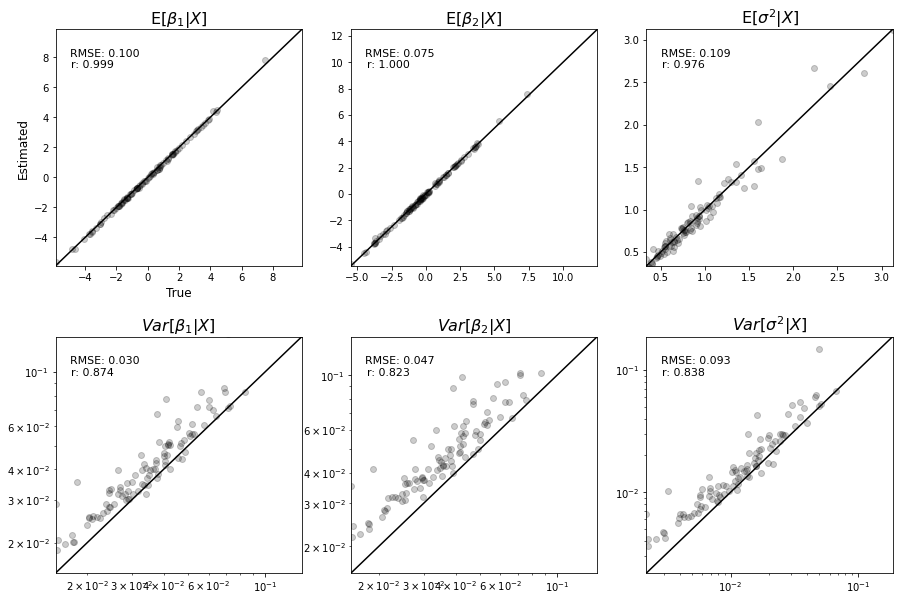

In [16]:
plot_analytic_vs_est(y_test, preds,NAMES,log=True,show=True,filename='result/results.png')